In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from othello.OthelloGame import OthelloGame as Game
from othello.OthelloGame import display as displayGame
from matplotlib import pyplot as plt
from matplotlib import patches
import numpy as np

In [8]:
def display_board(game, board, player_turn= None, valid_moves = None, figsize = (3, 3), ax = None):
    """(1 for white, -1 for black, 0 for empty spaces)"""
    ny, nx = board.shape
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize = figsize)
        f.patch.set_facecolor('lightgray')
    radius = 0.4
    if valid_moves is not None:
        board = board + 10*valid_moves[:n*n].reshape([n,n])
    for j, row in enumerate(board):
        for i, player in enumerate(row):
            if player_turn:
                if game.getGameEnded(board, 1) == 1:
                    ax.set_title('Gano Blanco')
                elif game.getGameEnded(board, -1) == 1:
                    ax.set_title('Gano Negro')
                elif game.getGameEnded(board, -1) == -0.2:
                    ax.set_title('Empate')
                elif player_turn == 1:
                    ax.set_title('Juega blanco')
                else:
                    ax.set_title('Juega negro')
            ypos = ny - j - 1
            xpos = i
            if player == 1:
                circle = patches.Circle([xpos, ypos], radius, color='w')
                ax.add_patch(circle)
            elif player == -1:
                circle = patches.Circle([xpos, ypos], radius, color='k')
                ax.add_patch(circle)
            elif player == 0:
                circle = patches.Circle([xpos, ypos], radius, color='gray', alpha=0.1)
                ax.add_patch(circle)
            elif player == 10:
                circle = patches.Circle([xpos, ypos], radius, color='gray', alpha=0.1)
                ax.add_patch(circle)
                circle = patches.Circle([xpos, ypos], 
                                        radius, 
                                        fill = False,
                                        linewidth=1, 
                                        color='k',
                                        linestyle='-')
                ax.add_patch(circle)
           
    ax.axis('off')
    ax.set_xlim([-0.5, nx - 0.5])
    ax.set_ylim([-0.5, ny - 0.5])
    ax.set_facecolor([0.5, 0.5, 0.5])

In [9]:
def random_player(game, board):
    valid_modes = game.getValidMoves(board, 1)
    valid_moves_idxs = np.where(valid_modes == 1)[0]
    action = np.random.choice(valid_moves_idxs)
    return action

def greedy_player(game, board):
    valids = np.array(game.getValidMoves(board, 1))
    scores = []
    indexes = []
    for a in np.where(valids == 1)[0]:
        nextBoard, _ = game.getNextState(board, 1, a)
        score = game.getScore(nextBoard, 1)
        scores.append(score)
        indexes.append(a)
    scores_indxs = np.where(np.array(scores) == max(scores))[0]    
    return indexes[np.random.choice(scores_indxs)]

In [11]:
def play_episode(players, game, board):
    # No necesita el jugador que comienza por que se resuelve en su forma canonica. 
    # Se ve el juego en la perspectiva de blanco siempre
    # board = game.getCanonicalForm(board, 1)
    states = []
    player_turn = 0
    while game.getGameEnded(board, 1) == 0:
        states.append(board)
        action = players[player_turn](game, board)
        board, _ = game.getNextState(board, 1, action)
        board = game.getCanonicalForm(board, -1)
        player_turn = (player_turn + 1) % len(players)
    states.append(board)
    return states



In [12]:
def plot_episode(game, states, initial_player=1):
    player_turn = initial_player
    cols = 6
    rows = int(np.ceil(len(states)/cols))
    f, axs = plt.subplots(rows, cols, figsize = (cols*3, 3*rows))
    f.patch.set_facecolor('lightgray')
    for i in range(cols*rows):
        ax = axs[int(i/cols), i%cols]
        ax.axis('off')
        if i<len(states):
            display_board(game, states[i] * player_turn, player_turn = player_turn, ax = ax)
            player_turn = -1 * player_turn
           

In [13]:
# Defino juego
n = 4
game = Game(n)
board = game.getInitBoard()

In [14]:
# Juego episodio
player = 1
# La razon por la que le paso board*player es para que la posición de comienzo sea la misma siempre
states = play_episode([random_player, greedy_player], game, board*player)
print('longitud episodio:', len(states))

longitud episodio: 13


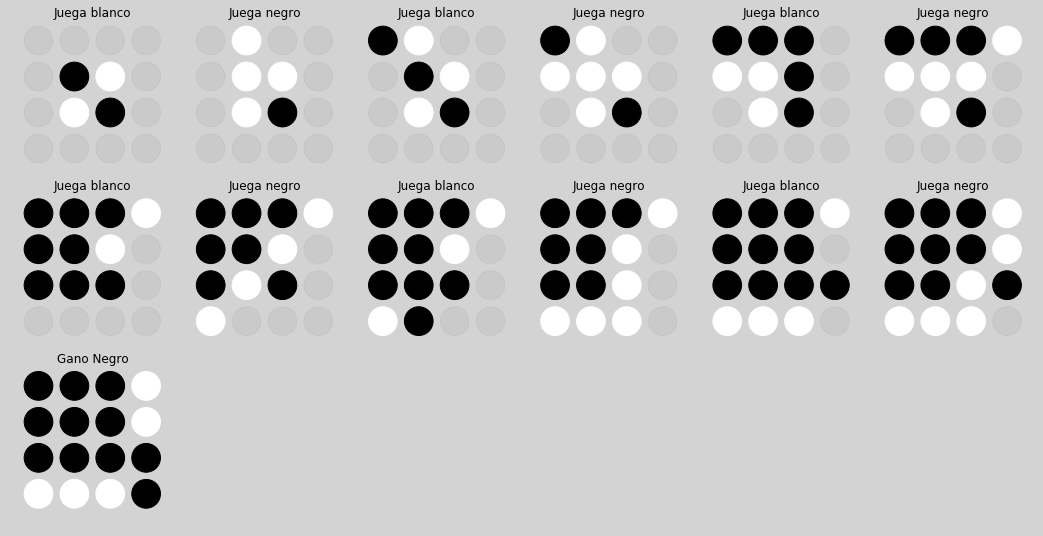

In [15]:
# Grafico episodio
plot_episode(game, states, initial_player = player)

In [16]:
states[-3]

array([[-1, -1, -1,  1],
       [-1, -1, -1,  0],
       [-1, -1, -1, -1],
       [ 1,  1,  1,  0]])

# preguntas:
- Cuanto esperaria que sea la longitud de cada episodio siempre? (tener en cuenta el numero de espacios libres): 12
- Cuanto suele ser y por que?: mayor a 12
- Puede ser menos que 12? si, cuando ninguno puede mover mas

# Pruebas con Greedy y Random players

In [27]:
n = 4
game = Game(n)
board = game.getInitBoard()

In [34]:
from playing_stats import EvaluatePolicy
evalPolicy = EvaluatePolicy(None)

## Random vs Random

In [48]:
# https://en.wikipedia.org/wiki/Computer_Othello
# Esta demostrado que para 'perfect play', el jugador que juega segundo gana
episodes = 10000
player_1_wins, player_2_wins, ties = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: evalPolicy.random_player, -1: evalPolicy.random_player}, 
                                                episodes)
print('player_1 wins:', str(int(100*player_1_wins/episodes + 0.5)) + '%')
print('player_2 wins:', str(int(100*player_2_wins/episodes + 0.5)) +'%')
print('ties:', str(int(100*ties/episodes + 0.5))+ '%')

player_1 wins: 34%
player_2 wins: 56%
ties: 9%


## Random vs Greedy
### El greedy juega primero

In [50]:
episodes = 10000
player_1_wins, player_2_wins, ties = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: evalPolicy.greedy_player, -1: evalPolicy.random_player}, 
                                                episodes)
print('player_1 wins:', str(int(100*player_1_wins/episodes + 0.5)) + '%')
print('player_2 wins:', str(int(100*player_2_wins/episodes + 0.5)) +'%')
print('ties:', str(int(100*ties/episodes + 0.5))+ '%')

player_1 wins: 36%
player_2 wins: 52%
ties: 12%


### El greedy juega segundo

In [49]:
episodes = 10000
player_1_wins, player_2_wins, ties = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: evalPolicy.random_player, -1: evalPolicy.greedy_player}, 
                                                episodes)
print('player_1 wins:', str(int(100*player_1_wins/episodes + 0.5)) + '%')
print('player_2 wins:', str(int(100*player_2_wins/episodes + 0.5)) +'%')
print('ties:', str(int(100*ties/episodes + 0.5))+ '%')

player_1 wins: 40%
player_2 wins: 52%
ties: 8%


Notar que el greedy no es mucho mejor que jugar random

# Greedy vs Greedy

In [51]:
episodes = 10000
player_1_wins, player_2_wins, ties = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: evalPolicy.greedy_player, -1: evalPolicy.greedy_player}, 
                                                episodes)
print('player_1 wins:', str(int(100*player_1_wins/episodes + 0.5)) + '%')
print('player_2 wins:', str(int(100*player_2_wins/episodes + 0.5)) +'%')
print('ties:', str(int(100*ties/episodes + 0.5))+ '%')

player_1 wins: 43%
player_2 wins: 49%
ties: 8%


El segundo siempre suele ganar